Loading data

In [ ]:
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from model.MLP_enzymes import MLP_enzymes
from model.random_forest_enzymes import random_forest_enzymes
from utils import initialize_esm_client
from utils.esmc_embedding import esmc_embedding
from utils.evaluation_metrics import evaluation_metrics
from utils.get_features import get_features
from utils.load_fasta import load_fasta
from utils.split_test_train import split_test_train
from utils.train_mlp import train_mlp

# Path to FASTA files
enzyme_path = 'data/enzyme/enzyme.fasta'
not_enzyme_path = 'data/not_enzyme/not_enzyme.fasta'

# Load FASTA files to Seq
enzyme, not_enzyme = load_fasta(enzyme_path, not_enzyme_path)

# Create features of every sequence
enzyme_features = get_features(enzyme)
not_enzyme_features = get_features(not_enzyme)



enzyme_embedding = Parallel(n_jobs=-1, verbose=10, prefer='processes',
                            initializer=initialize_esm_client.initialize_esm_client)(
    delayed(esmc_embedding)(str(sequence))
    for sequence in enzyme
)

not_enzyme_embedding = Parallel(n_jobs=-1, verbose=10, prefer='processes',
                                initializer=initialize_esm_client.initialize_esm_client)(
    delayed(esmc_embedding)(str(sequence))
    for sequence in not_enzyme
)


print(enzyme_embedding)

# Split data into train and test sets
x_train, x_test, y_train, y_test = split_test_train(enzyme_features, not_enzyme_features)

[Parallel(n_jobs=1)]: Done   0 out of   1 | elapsed:    0.0s remaining:    0.0s


NameError: name '_client' is not defined

Random Forest

In [2]:
# Create random forest model
model_random_forest = random_forest_enzymes(x_train, y_train)

# Predictions of random forest model
y_predict_rf = model_random_forest.predict(x_test)

# Calculate evaluation metrics of rf model
accuracy_rf, f1_rf, conf_matrix_rf = evaluation_metrics(y_test, y_predict_rf)

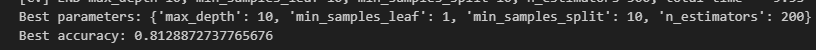

MLP

In [1]:
# Transform data sets into tensors
x_test_tensor = torch.tensor(x_test.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)
x_train_tensor = torch.tensor(x_train.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)

# Create MLP model
input_len = len(x_test_tensor[1])
print(input_len)
model_MLP = MLP_enzymes(input_len)

# Train model
train_mlp(model_MLP, x_train_tensor, y_train_tensor)

# Set model to evaluate
model_MLP.eval()

# Get predicted value
with torch.no_grad():
    y_predict_MLP = model_MLP(x_test_tensor)

    _, predicted_classes_MLP = torch.max(y_predict_MLP, 1)

# Transform predicted values to numpy
predicted_classes_MLP_npy = predicted_classes_MLP.cpu().numpy()

# Get evaluation metrics of MLP model
accuracy_MLP, f1_MLP, conf_matrix_MLP = evaluation_metrics(y_test, predicted_classes_MLP_npy)

NameError: name 'torch' is not defined

Results

---------- RANDOM FOREST ----------
Accuracy 0.8241
F1 Score 0.8319
[[1254  358]
 [ 209 1403]]
---------- MLP ----------
Accuracy 0.8154
F1 Score 0.8271
[[1206  406]
 [ 189 1423]]


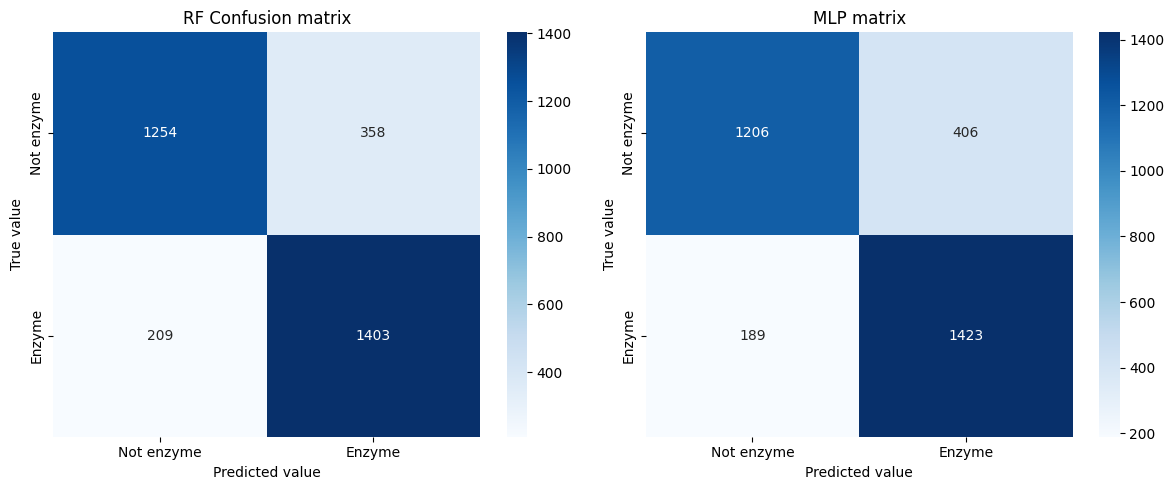

In [4]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Print evaluation metrics of RF
print("---------- RANDOM FOREST ----------")
print(f"Accuracy {accuracy_rf:.4f}")
print(f"F1 Score {f1_rf:.4f}")
print(f"{conf_matrix_rf}")

# Create RF heatmap of conf_matrix
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not enzyme', 'Enzyme'], yticklabels=['Not enzyme', 'Enzyme'],
            ax=axes[0])
axes[0].set_title('RF Confusion matrix')
axes[0].set_ylabel('True value')
axes[0].set_xlabel('Predicted value')

# Print evaluation metrics of MLP
print("---------- MLP ----------")
print(f"Accuracy {accuracy_MLP:.4f}")
print(f"F1 Score {f1_MLP:.4f}")
print(f"{conf_matrix_MLP}")

# Create MLP heatmap of conf_matrix
sns.heatmap(conf_matrix_MLP, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not enzyme', 'Enzyme'], yticklabels=['Not enzyme', 'Enzyme'],
            ax=axes[1])
axes[1].set_title('MLP matrix')
axes[1].set_ylabel('True value')
axes[1].set_xlabel('Predicted value')

# Print heatmaps
plt.tight_layout()
plt.show()